In [86]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
from proj1_helpers import *
from helpers2 import *

In [88]:
#data_folder = Path("../data/")
DATA_TRAIN_PATH = "../data/train.csv"
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Data analysis

In [89]:
print(y)
print(np.shape(y))
print(np.shape(tX))
print(tX.dtype)
print(y.dtype)

[ 1. -1. -1. ...  1. -1. -1.]
(250000,)
(250000, 30)
float64
float64


In [90]:
feature_names = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 
                 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 
                 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 
                 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 
                 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi',
                 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']

for i, name in enumerate(feature_names):
    print(i, feature_names[i])


0 DER_mass_MMC
1 DER_mass_transverse_met_lep
2 DER_mass_vis
3 DER_pt_h
4 DER_deltaeta_jet_jet
5 DER_mass_jet_jet
6 DER_prodeta_jet_jet
7 DER_deltar_tau_lep
8 DER_pt_tot
9 DER_sum_pt
10 DER_pt_ratio_lep_tau
11 DER_met_phi_centrality
12 DER_lep_eta_centrality
13 PRI_tau_pt
14 PRI_tau_eta
15 PRI_tau_phi
16 PRI_lep_pt
17 PRI_lep_eta
18 PRI_lep_phi
19 PRI_met
20 PRI_met_phi
21 PRI_met_sumet
22 PRI_jet_num
23 PRI_jet_leading_pt
24 PRI_jet_leading_eta
25 PRI_jet_leading_phi
26 PRI_jet_subleading_pt
27 PRI_jet_subleading_eta
28 PRI_jet_subleading_phi
29 PRI_jet_all_pt


The training data set is composed of : 
* a y vector of length 250'000 and type float
* a tX float matrix of 250'000 rows and 30 columns

It means that our data set is composed of 250'000 different obsevations of 30 different features. In the rest of the notebook, we name the features by their index nummer. So, it means from the feature 0 from the feature  29.

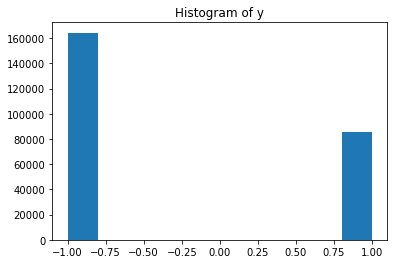

In [91]:
plt.hist(y)
plt.title('Histogram of y')
plt.show()

There is more y = -1 than y = 1 in the data, so there is more y = 'b' than y = 's'. So, we have to pay attention to normalize the data in order to compare them in the next plots.

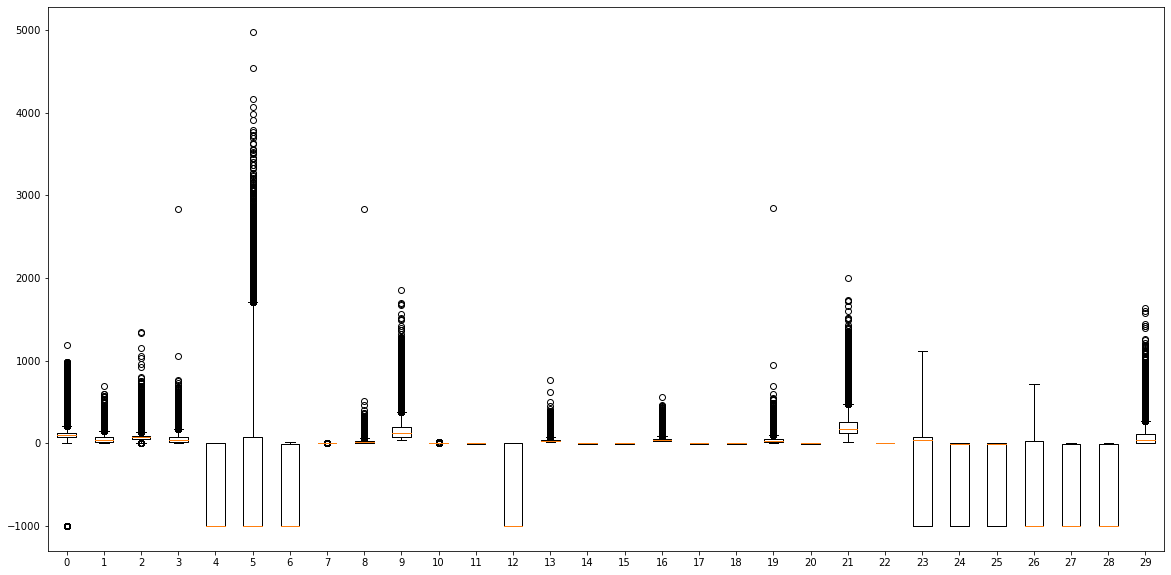

In [92]:
plt.figure(figsize=(20, 10))
ind = np.arange(30)
plt.boxplot(tX[:,], labels = ind)

plt.show()

There are many outliers depending on the feature. There are also feature that has a long interquantile range. Maybe we have to treat these feature in order to be more efficient in our futur predictions. Let's do more plots to be have a better idea :

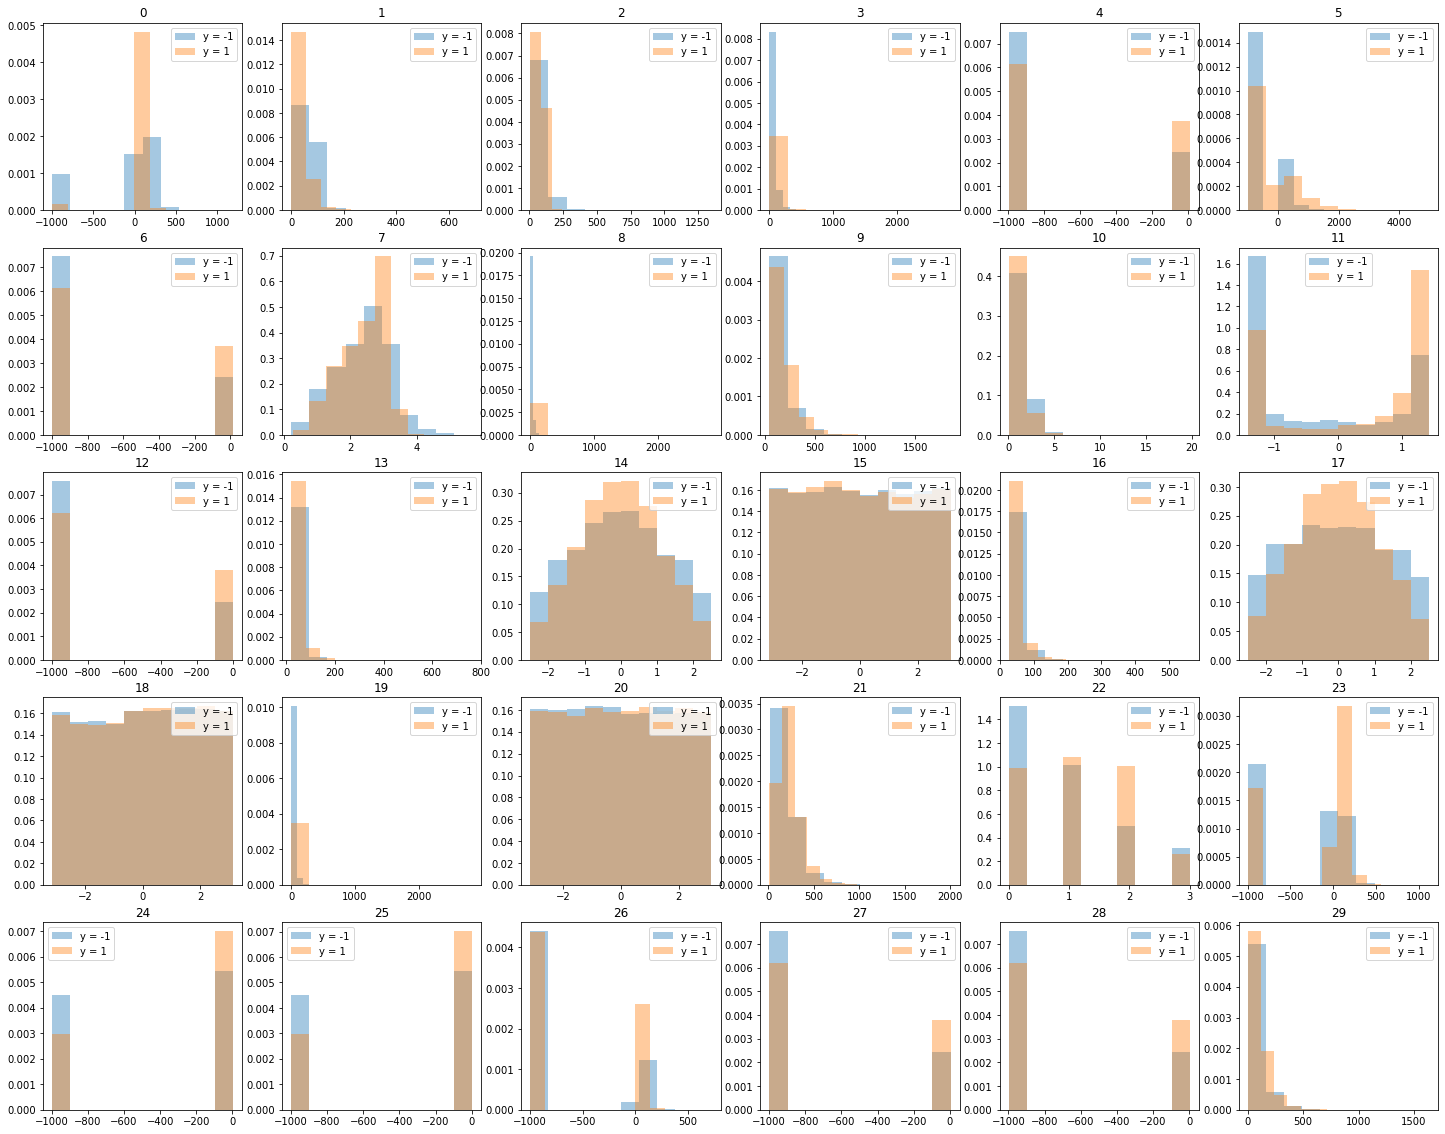

In [93]:
ind_1 = np.where(y == 1)
ind_2 = np.where(y == -1)
tX_1 = tX[ind_1[0],:]
tX_2 = tX[ind_2[0],:]

fig, axs = plt.subplots(5, 6, figsize=(25,20))

n = 0
for i in range(5) :
    for j in range(6) :
        axs[i,j].hist(tX_2[:,n], alpha=0.4, density=True, label=['y = -1'])
        axs[i,j].hist(tX_1[:,n], alpha=0.4, density=True, label=['y = 1'])
        axs[i,j].legend()
        axs[i,j].set_title(n)
        n = n + 1
plt.show()

By plotting the histograms of the features with a color for each y, we can see that there are useless features as they have almost the same distribution for y=1 than for y = -1. We can cut feature 15, 18, 20. 


There are also features that are very inequally distributed with value that are about -1000 and values around 0 ; it can be problematic for the prediction with such a large gap between values of a single distribution. Moreover, there is not a big difference in the distribution of y=1 and y=-1. Maybe it can be useful to put off these big negative values of these features. The features in question are : 0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28.


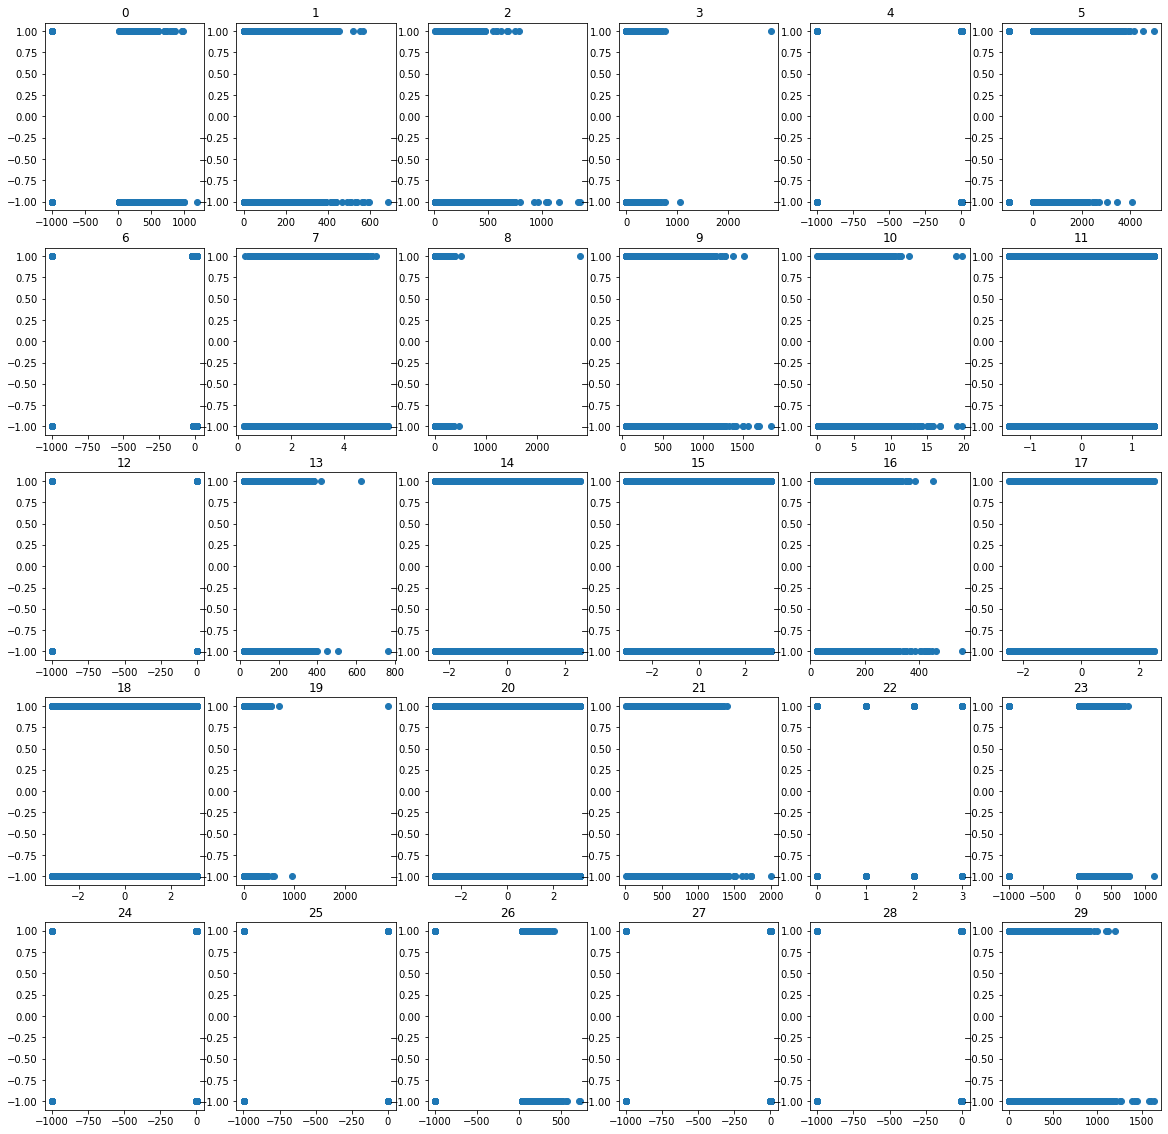

In [94]:
fig, axs = plt.subplots(5, 6, figsize=(20,20))

n = 0
for i in range(5) :
    for j in range(6) :
        axs[i,j].scatter(tX[:,n], y)
        axs[i,j].set_title(n)
        n = n + 1
plt.show()

#meme constat comment faire pour se debarrasser de ces valeurs ??

These plots confirm the obsevations that we made in the previous plot ; no difference of the distribution of y for features 15, 18, 20 and very large gap in the distributions of features : 0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28.

## Data filtering

### Outliers

In [96]:
def nb_outliers(tX, outlier) : 
    sum = 0
    nb_outliers = []
    for col in range(tX.shape[1]) :
        sum = np.where(tX[:,col] == outlier)[0].shape
        nb_outliers.append(sum)   
    print(nb_outliers)
    print(np.where(tX==outlier)[0].shape)

out = -999

print('number of -999 in the entire matrix :')
nb_outliers(tX, out)

ind_1 = np.where(y == 1)
ind_2 = np.where(y == -1)
tX_1 = tX[ind_1[0],:]
tX_2 = tX[ind_2[0],:]

print('number of -999 in the rows where y = 1 :')
nb_outliers(tX_1, out)
print('number of -999 in the rows where y = -1 :')
nb_outliers(tX_2, out)

number of -999 in the entire matrix :
[(38114,), (0,), (0,), (0,), (177457,), (177457,), (177457,), (0,), (0,), (0,), (0,), (0,), (177457,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (99913,), (99913,), (99913,), (177457,), (177457,), (177457,), (0,)]
(1580052,)
number of -999 in the rows where y = 1 :
[(2835,), (0,), (0,), (0,), (53202,), (53202,), (53202,), (0,), (0,), (0,), (0,), (0,), (53202,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (25492,), (25492,), (25492,), (53202,), (53202,), (53202,), (0,)]
(451725,)
number of -999 in the rows where y = -1 :
[(35279,), (0,), (0,), (0,), (124255,), (124255,), (124255,), (0,), (0,), (0,), (0,), (0,), (124255,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (74421,), (74421,), (74421,), (124255,), (124255,), (124255,), (0,)]
(1128327,)


We have a problem with features  0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28. They are inequally distributed; they have a lot of -999 values and the rest is values around 0. So, here we can see how much of these -999 there are. We can see that the -999 appear only in the features that we identified with the histograms. It seems that there is a correlation between features as many features have the same number of -999. We can also see that there is more -999 in the obsevations where y=-1, so we have to take this into account when we filter the data. As there are many -999, we can't delete the rows where there is -999 because we will loose to much information.

Explication sets

In [ ]:
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX, y, ids)

print('Set 1')
set1_x = outliers(set1_x, -999)
_ = outliers(set1_x, -999)

print('\nSet 2')
set2_x = outliers(set2_x, -999)
_ = outliers(set2_x, -999)

print('\nSet 3')
set3_x = outliers(set3_x, -999)
_ = outliers(set3_x, -999)

TEST FOR y=[0,1]

In [ ]:
print(y)
y[y==-1]=0
print(y)

In order to filter the data, we want to get rif of these -999, but we can't just delete the rows. So, we have the idea to replace the -999 by the mean of the rest of values of the feature. As there is a significant difference of amount of -999 in between y=1 and y=-1 in certain features, we calculate the mean for the rows where y = 1 and y = -1 separatly.

Then, we can also standardize the data. It can be a good idea because the features are not all in the same range of values and it can create disproportionality between the importance of the features.

As we see above in the histograms, some features seem to be useless as they have a similar distribution between the y = 1 and y = -1. So, it is useful to have function that cut or keep some parameters.

In [ ]:
to_log = [1, 2, 5, 9, 10, 13, 16, 19, 21, 23, 26, 29]
with_gaps = [0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28]
to_log2 = [7, 8, 10, 11, 19]

## Fonctions 

In [ ]:
from implementations import *
from cross_validation import *

### Least squares

The best results for least squares regression is with the tX matrix which is standardize, filter with filtering_with_mean_bis function and whose features 15, 18, 20 are cut :

In [ ]:
x_essai = x4
degrees = np.arange(1,11)
degree_opt, _ = best_degree_selection(y, x_essai, degrees, k_fold=10, lambdas=0, fonction=0)
print("Cross validation finished: optimal degree {d}".format(d=degree_opt))
tX_poly = build_poly(x_essai, degree_opt)
w_ls, loss_ls = least_squares(y, tX_poly)
print("Least square loss rmse {loss}".format(loss=np.sqrt(loss_ls)))
degree_ls = degree_opt
#deg= ,test_rmse= 0.8094823719446076, train_rmse=0.5723030100580346

The least squares best model is degree 1 ; its accuracy is : 0.606

### Ridge regression 

The best results for Ridge regression is with tX that is only filtered by filtering_with_mean_bis function : 

In [ ]:
degrees = np.arange(1,8)
x_essai = x1
degree_opt, lambda_opt = best_degree_selection(y, x_essai, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
x_essai = build_poly(x_essai, degree_opt)
w_rr, loss_rr = ridge_regression(y, x_essai, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
degree_rr = degree_opt

Let's look if we can improve the results with the separation of tX into sets according to the feature 22 (PRI_jet_num) : 

In [ ]:
set1_x_rr = filtering_with_mean_bis(set1_x, set1_y)

set2_x_rr = filtering_with_mean_bis(set2_x, set2_y)

set3_x_rr = filtering_with_mean_bis(set3_x, set3_y)

Ridge regression according to the different sets : 

In [ ]:
degrees = np.arange(1,8)
x_essai = set1_x_rr
y = set1_y
degree_opt, lambda_opt = best_degree_selection(y, x_essai, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
x_essai = build_poly(x_essai, degree_opt)
w_rr_set1, loss_rr = ridge_regression(y, x_essai, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
lambda_rr_set1 = lambda_opt
degree_rr_set1 = degree_opt

In [ ]:
degrees = np.arange(1,8)
x_essai = set2_x_rr
y = set2_y
degree_opt, lambda_opt = best_degree_selection(y, x_essai, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
x_essai = build_poly(x_essai, degree_opt)
w_rr_set2, loss_rr = ridge_regression(y, x_essai, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
lambda_rr_set2 = lambda_opt
degree_rr_set2 = degree_opt

In [ ]:
degrees = np.arange(1,8)
x_essai = set3_x_rr
y = set3_y
degree_opt, lambda_opt = best_degree_selection(y, x_essai, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
x_essai = build_poly(x_essai, degree_opt)
w_rr_set3, loss_rr = ridge_regression(y, x_essai, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
lambda_rr_set3 = lambda_opt
degree_rr_set3 = degree_opt

We have better results with the matrix that is separated in sets, so let's do a submission with this method. The submission is better without filtering_with_mean on the test sets. We had 0.802 of accuracy with the filtering_with_mean function and 0.804 without.

### Gradient descent

We process the data to get better results 

In [ ]:
#set1_x_gd = log_distribution(set1_x_gd, to_log)
set1_x_gd = filtering_with_mean_bis(set1_x_gd, set1_y)
#set1_x_gd = std(set1_x_gd)

#set2_x_gd = log_distribution(set2_x_gd, to_log)
set2_x_gd = filtering_with_mean_bis(set2_x_gd, set2_y)
#set2_x_gd = std(set2_x_gd)

#set3_x_gd = log_distribution(set3_x_gd, to_log)
set3_x_gd = filtering_with_mean_bis(set3_x_gd, set3_y)
#set3_x_gd = std(set3_x_gd)

In the next cells, we perform a 4-fold cross validation for the gamma parameter for gradient descent method for each set. Then we we perform a stochastic gradient descent with the optimal gamma found. For the cross validation we use 50 iterations and for the final descent 500 iterations as we want a more precise final result. 

In [ ]:
k_fold = 4
max_iters = 500
initial_w = np.zeros(set1_x_gd.shape[1])
gammas = np.arange(0, 3, 0.01)
gamma_opt1 = cross_validation(set1_y, set1_x_gd, k_fold, gammas, fonction=2)
w_gd1, loss_gd1 = least_squares_GD(set1_y, set1_x_gd, gamma_opt1, max_iters=max_iters)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt1))
print("Gradient descent regression loss {loss}".format(loss=loss_gd1))

In [ ]:
k_fold = 4
max_iters = 500
initial_w = np.zeros(set2_x_gd.shape[1])
gammas = np.arange(0, 3, 0.01)
gamma_opt2 = cross_validation(set2_y, set2_x_gd, k_fold, gammas, fonction=2)
w_gd2, loss_gd2 = least_squares_GD(set2_y, set2_x_gd, gamma_opt2, max_iters=max_iters)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt2))
print("Gradient descent regression loss {loss}".format(loss=loss_gd2))

In [ ]:
k_fold = 4
max_iters = 500
initial_w = np.zeros(set3_x_gd.shape[1])
gammas = np.arange(0, 3, 0.01)
gamma_opt3 = cross_validation(set3_y, set3_x_gd, k_fold, gammas, fonction=2)
w_gd3, loss_gd3 = least_squares_GD(set3_y, set3_x_gd, gamma_opt3, max_iters=max_iters)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt3))
print("Gradient descent regression loss {loss}".format(loss=loss_gd3))

### Stochastic gradient descent

In [ ]:
#set1_x_sgd = log_distribution(set1_x_sgd, to_log)
set1_x_sgd = filtering_with_mean_bis(set1_x_sgd, set1_y)
#set1_x_sgd = std(set1_x_sgd)

#set2_x_sgd = log_distribution(set2_x_sgd, to_log)
set2_x_sgd = filtering_with_mean_bis(set2_x_sgd, set2_y)
#set2_x_sgd = std(set2_x_sgd)

#set3_x_sgd = log_distribution(set3_x_sgd, to_log)
set3_x_sgd = filtering_with_mean_bis(set3_x_sgd, set3_y)
#set3_x_sgd = std(set3_x_sgd)

In the next cells, we perform a 4-fold cross validation for the gamma parameter for stochastic gradient descent method for each set. Then we we perform a stochastic gradient descent with the optimal gamma found. For the cross validation we use 50 iterations and for the final descent 500 iterations as we want a more precise final result. 

In [ ]:
k_fold = 4
gammas = np.arange(0, 1, 0.01)
gamma_opt_sgd1 = cross_validation(set1_y, set1_x_sgd, k_fold, gammas, fonction=3)
w_sgd1, loss_sgd1 = least_squares_SGD(set1_y, set1_x_sgd, gamma_opt_sgd1, max_iters=500)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt_sgd1))
print("Stochastic gradient descent regression loss {loss}".format(loss=loss_sgd1))

In [ ]:
k_fold = 4
gammas = np.arange(0, 1, 0.01)
gamma_opt2 = cross_validation(set2_y, set2_x_sgd, k_fold, gammas, fonction=3)
w_sgd2, loss_sgd2 = least_squares_SGD(set2_y, set2_x_sgd, gamma_opt2, max_iters=500)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt2))
print("Stochastic gradient descent regression loss {loss}".format(loss=loss_sgd2))

In [ ]:
k_fold = 4
gammas = np.arange(0, 1, 0.01)
gamma_opt3 = cross_validation(set3_y, set3_x_sgd, k_fold, gammas, fonction=3)
w_sgd3, loss_sgd3 = least_squares_SGD(set3_y, set3_x_sgd, gamma_opt3, max_iters=500)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt3))
print("Stochastic gradient descent regression loss {loss}".format(loss=loss_sgd3))

### Logistic regression

In [ ]:
#set1_x_lr = log_distribution(set1_x_lr, to_log)
set1_x_lr = filtering_with_mean_bis(set1_x_lr, set1_y)
#set1_x_lr = std(set1_x_lr)

#set2_x_lr = log_distribution(set2_x_lr, to_log)
set2_x_lr = filtering_with_mean_bis(set2_x_lr, set2_y)
#set2_x_lr = std(set2_x_lr)

#set3_x_lr= log_distribution(set3_x_lr, to_log)
set3_x_lr = filtering_with_mean_bis(set3_x_lr, set3_y)
#set3_x_lr = std(set3_x_lr)

In [84]:
max_iters = 500
#np.append(tx, np.ones((tx.shape[0],1)), axis=1)
k_fold = 4
initial_w = np.zeros(tX.shape[1])
gammas = np.arange(0, 1, 0.01)
#gamma = 0.01
gamma_opt = cross_validation(y, tX, k_fold, gammas, fonction=4)
w_lr, loss_lr = logistic_regression(y, tX, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt))
print("logistic regression loss {loss}".format(loss=loss_lr))

Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=129965.09635498974
Current iteration=4, loss=129965.09635498974
Current iteration=6, loss=129965.09635498974
Current iteration=8, loss=129965.09635498974
loss=129965.09635498974
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=129965.09635498974
Current iteration=4, loss=129965.09635498974
Current iteration=6, loss=129965.09635498974
Current iteration=8, loss=129965.09635498974
loss=129965.09635498974
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=129965.09635498974
Current iteration=4, loss=129965.09635498974
Current iteration=6, loss=129965.09635498974
Current iteration=8, loss=129965.09635498974
loss=129965.09635498974
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=129965.09635498974
Current iteration=4, loss=129965.09635498974
Current iteration=6, loss=129965.09635498974
Current iteration=8, loss=129965.0963549

/home/julia/Desktop/Ma1/Machine_Learning/Projet1/code_local/scripts/helpers2.py:83: RuntimeWarning: overflow encountered in exp
  sig = (1 + np.exp(-t))**(-1)
/home/julia/Desktop/Ma1/Machine_Learning/Projet1/code_local/scripts/helpers2.py:104: RuntimeWarning: overflow encountered in exp
  loss = np.sum(np.log(1 + np.exp(tx.dot(w))) - y.dot(tx.dot(w)))
/home/julia/Desktop/Ma1/Machine_Learning/Projet1/code_local/scripts/helpers2.py:112: RuntimeWarning: overflow encountered in exp
  grad = tx.T.dot(1/(1 + np.exp(-tx.dot(w))) - y)


Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500

Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iterati

(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2

Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iterati

Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss

Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500

Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iterati

Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500

Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(62500, 1)
Current iteration=0, loss=129965.09635498974
Current iteration=2, loss=inf


Current iteration=46, loss=173286.79513998624
Current iteration=48, loss=173286.79513998624
Current iteration=50, loss=173286.79513998624
Current iteration=52, loss=173286.79513998624
Current iteration=54, loss=173286.79513998624
Current iteration=56, loss=173286.79513998624
Current iteration=58, loss=173286.79513998624
Current iteration=60, loss=173286.79513998624
Current iteration=62, loss=173286.79513998624
Current iteration=64, loss=173286.79513998624
Current iteration=66, loss=173286.79513998624
Current iteration=68, loss=173286.79513998624
Current iteration=70, loss=173286.79513998624
Current iteration=72, loss=173286.79513998624
Current iteration=74, loss=173286.79513998624
Current iteration=76, loss=173286.79513998624
Current iteration=78, loss=173286.79513998624
Current iteration=80, loss=173286.79513998624
Current iteration=82, loss=173286.79513998624
Current iteration=84, loss=173286.79513998624
Current iteration=86, loss=173286.79513998624
Current iteration=88, loss=173286.

Current iteration=398, loss=173286.79513998624
Current iteration=400, loss=173286.79513998624
Current iteration=402, loss=173286.79513998624
Current iteration=404, loss=173286.79513998624
Current iteration=406, loss=173286.79513998624
Current iteration=408, loss=173286.79513998624
Current iteration=410, loss=173286.79513998624
Current iteration=412, loss=173286.79513998624
Current iteration=414, loss=173286.79513998624
Current iteration=416, loss=173286.79513998624
Current iteration=418, loss=173286.79513998624
Current iteration=420, loss=173286.79513998624
Current iteration=422, loss=173286.79513998624
Current iteration=424, loss=173286.79513998624
Current iteration=426, loss=173286.79513998624
Current iteration=428, loss=173286.79513998624
Current iteration=430, loss=173286.79513998624
Current iteration=432, loss=173286.79513998624
Current iteration=434, loss=173286.79513998624
Current iteration=436, loss=173286.79513998624
Current iteration=438, loss=173286.79513998624
Current itera

In [85]:
max_iters = 500
k_fold = 4
initial_w = np.zeros(set2_x.shape[1])
gammas = np.arange(0, 1, 0.01)
gamma_opt = cross_validation(set2_y, set2_x, k_fold, gammas, fonction=4)
w_lr, loss_lr = logistic_regression(y,tx, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt))
print("logistic regression loss {loss}".format(loss=loss_lr))

Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=40312.053727005296
Current iteration=4, loss=40312.053727005296
Current iteration=6, loss=40312.053727005296
Current iteration=8, loss=40312.053727005296
loss=40312.053727005296
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=40312.053727005296
Current iteration=4, loss=40312.053727005296
Current iteration=6, loss=40312.053727005296
Current iteration=8, loss=40312.053727005296
loss=40312.053727005296
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=40312.053727005296
Current iteration=4, loss=40312.053727005296
Current iteration=6, loss=40312.053727005296
Current iteration=8, loss=40312.053727005296
loss=40312.053727005296
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=40312.053727005296
Current iteration=4, loss=40312.053727005296
Current iteration=6, loss=40312.053727005296
Current iteration=8, loss=40312.05372700

loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current it

Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386

Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386

Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss

Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iterati

loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current it

Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iterati

Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386, 1)
Current iteration=0, loss=40312.053727005296
Current iteration=2, loss=inf
Current iteration=4, loss=inf
Current iteration=6, loss=inf
Current iteration=8, loss=inf
loss=inf
(19386

NameError: name 'tx' is not defined

In [ ]:
max_iters = 500
k_fold = 4
initial_w = np.zeros(set3_x.shape[1])
gammas = np.arange(0, 1, 0.01)
gamma_opt = cross_validation(set3_y, set3_x, k_fold, gammas, fonction=4)
w_lr, loss_lr = logistic_regression(y,tx, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt))
print("logistic regression loss {loss}".format(loss=loss_lr))

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
test_set1_x, _, test_set1_ids, test_set2_x, _, test_set2_ids, test_set3_x, _, test_set3_ids = separate_sets(tX, y, ids)

test_set1_x = outliers(set1_x, -999)
test_set1_x = log_distribution(test_set1_x, to_log)
test_set1_x = filtering_with_mean_bis(test_set1_x, test_set1_y)
test_set1_x = std(test_set1_x)

test_set2_x = outliers(set2_x, -999)
test_set2_x = log_distribution(test_set2_x, to_log)
test_set2_x = filtering_with_mean_bis(test_set2_x, test_set2_y)
test_set2_x = std(test_set2_x)

test_set3_x = outliers(set3_x, -999)
test_set3_x = log_distribution(test_set3_x, to_log)
test_set3_x = filtering_with_mean_bis(test_set3_x, test_set3_y)
test_set3_x = std(test_set3_x)

#### Least squares submissions

In [ ]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
OUTPUT_PATH = '../data/pred_ls.csv' 
tX_test_ls = cut(std(filtering_with_mean(tX_test)),[15,18,20])
tX_test_ls = build_poly(tX_test_ls, degree_ls)
y_pred = predict_labels(w_ls, tX_test_ls)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

#### Ridge regression submissions

In [ ]:
OUTPUT_PATH = '../data/pred_set_rr.csv' 
DATA_TEST_PATH = '../data/test.csv'
y_test , tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

set1_x, _, set1_ids, set2_x, _, set2_ids, set3_x, _, set3_ids = separate_sets(tX_test, y_test, ids_test)

def filtering_test_rr (set_x, degree_rr):
    set_x = outliers(set_x, -999)
    #set_x = filtering_with_mean(set_x)
    set_x = build_poly(set_x, degree_rr)
    return set_x

set1_x = filtering_test_rr(set1_x, degree_rr_set1)
set2_x = filtering_test_rr(set2_x, degree_rr_set2)
set3_x = filtering_test_rr(set3_x, degree_rr_set3)
y_pred1 = predict_labels(w_rr_set1, set1_x)
y_pred2 = predict_labels(w_rr_set2, set2_x)
y_pred3 = predict_labels(w_rr_set3, set3_x)

y_pred_rr, ids_rr = concatenate_sets(y_pred1, set1_ids, y_pred2, set2_ids, y_pred3, set3_ids)
create_csv_submission(ids_rr, y_pred_rr, OUTPUT_PATH)

#### Gradient descent submissions

In [ ]:
OUTPUT_PATH = '../data/pred_sg.csv' # TODO: fill in desired name of output file for submission
tX_test_gd = concatenate_sets(test_set1_x, test_set1_y, test_set1_ids, test_set2_x, test_set2_y, test_set2_ids, 
                              test_set3_x, test_set3_y, test_set3_ids)
y_pred = predict_labels(w_gd, tX_test_gd)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

#### Stochastic gradient descent submissions

In [ ]:
OUTPUT_PATH = '../data/pred_sgd.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w_sgd, tX_test2)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)